---
title: "Lab 8"
format: 
  html:
    theme: lux
---

# Part One
I’m choosing ROC AUC because it gives a good overall performance measure for both classes, which is helpful when the data is unbalanced. Plus, it shows how well the model distinguishes between the classes, regardless of the decision threshold.

As seen below, the best model for predicting the type variable is SVC.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    classification_report,
    f1_score
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsOneClassifier
import plotnine as pn


In [1]:


url = "https://www.dropbox.com/s/s2a1uoiegitupjc/cannabis_full.csv?dl=1"
df = pd.read_csv(url)

df['Type'] = df['Type'].str.strip().str.title()
df_binary = df[df['Type'].isin(['Sativa', 'Indica'])]

X = df_binary.drop(columns=['Strain', 'Type', 'Effects', 'Flavor', 'Rating'])
y = df_binary['Type']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), X.columns)
    ]
)

lda_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearDiscriminantAnalysis())
])

lda_pipeline.fit(X_train, y_train)

y_pred = lda_pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average='macro')

print("Confusion Matrix:\n", conf_matrix)
print("ROC AUC Score:", roc_auc)


Features shape: (1139, 64)
Target shape: (1139,)
Confusion Matrix:
 [[166  15]
 [ 23  81]]
ROC AUC Score: 0.8479866128346791


In [2]:



df['Type'] = df['Type'].str.strip().str.title()
df_binary = df[df['Type'].isin(['Sativa', 'Indica'])]

X = df_binary.drop(columns=['Strain', 'Type', 'Effects', 'Flavor', 'Rating'])
y = df_binary['Type']

print("Features shape:", X.shape)
print("Target shape:", y.shape)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), X.columns)
    ]
)

qda_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', QuadraticDiscriminantAnalysis())
])

qda_pipeline.fit(X_train, y_train)

y_pred = qda_pipeline.predict(X_test)
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(pd.get_dummies(y_test), pd.get_dummies(y_pred), average='macro')

print("Confusion Matrix:\n", conf_matrix)
print("ROC AUC Score:", roc_auc)


Features shape: (1139, 64)
Target shape: (1139,)
Confusion Matrix:
 [[ 79 102]
 [ 26  78]]
ROC AUC Score: 0.593232044198895


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


In [3]:


svc_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC(probability=True))
])

param_grid = {
    'model__C': [0.1, 1, 10],
    'model__kernel': ['linear', 'rbf'],
    'model__gamma': ['scale', 'auto']
}

grid_search = GridSearchCV(svc_pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_svc = grid_search.best_estimator_

y_pred = best_svc.predict(X_test)
y_prob = best_svc.predict_proba(X_test)[:, 1]
conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test.map({'Sativa': 1, 'Indica': 0}), y_prob)

print("Best Parameters:", grid_search.best_params_)
print("Confusion Matrix:\n", conf_matrix)
print("ROC AUC Score:", roc_auc)


Best Parameters: {'model__C': 0.1, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Confusion Matrix:
 [[175   6]
 [ 50  54]]
ROC AUC Score: 0.9311517212069698


In [4]:


X = df.drop(columns=['Type'])
y = df['Type']
categorical_columns = X.select_dtypes(include=['object']).columns
numerical_columns = X.select_dtypes(exclude=['object']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), numerical_columns),
        ('cat', Pipeline([
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('onehot', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_columns)
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC(kernel='poly', degree=3, coef0=1, probability=True))
])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

pipeline.fit(X_train, y_train)

y_pred = pipeline.predict(X_test)

conf_matrix = confusion_matrix(y_test, y_pred)
roc_auc = roc_auc_score(y_test, pipeline.predict_proba(X_test), multi_class='ovr')

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print(f"\nROC AUC Score: {roc_auc}")


Confusion Matrix:
[[218  59  35]
 [ 69  95   6]
 [ 71   2  33]]

Classification Report:
              precision    recall  f1-score   support

      Hybrid       0.61      0.70      0.65       312
      Indica       0.61      0.56      0.58       170
      Sativa       0.45      0.31      0.37       106

    accuracy                           0.59       588
   macro avg       0.55      0.52      0.53       588
weighted avg       0.58      0.59      0.58       588


ROC AUC Score: 0.7412282498966846


# Part Two
### Q1

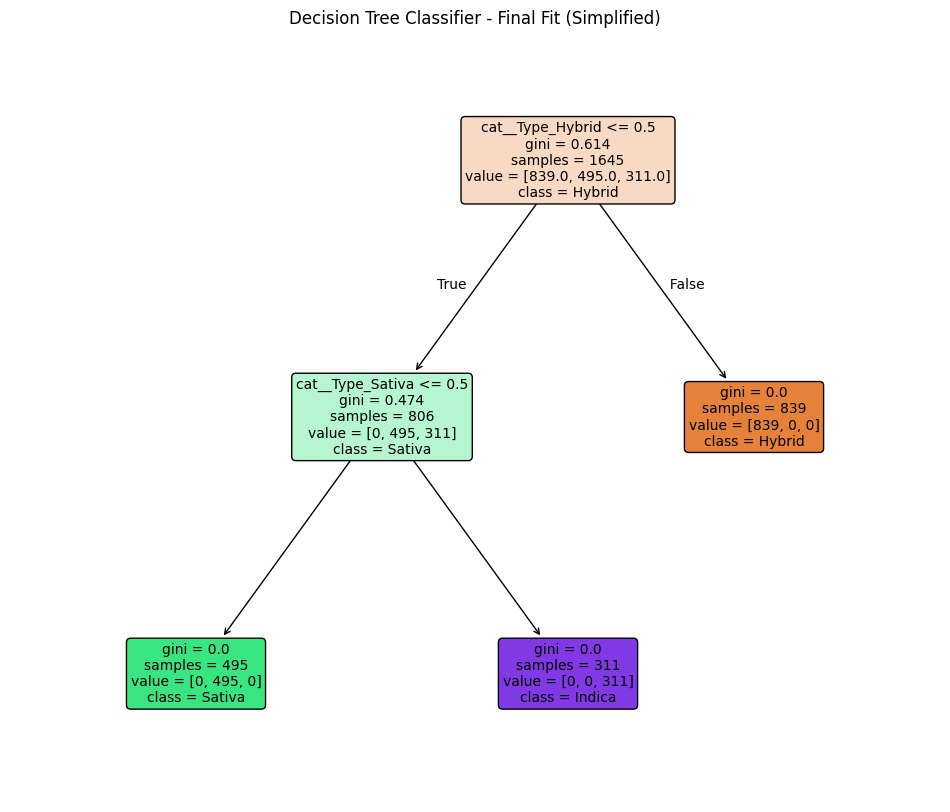

Training Accuracy: 1.00
Test Accuracy: 1.00


In [5]:


feature_columns = ['Strain', 'Type', 'Rating', 'Effects', 'Flavor']

X_full = df[feature_columns]
y_full = df['Type']

X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

column_transformer = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Strain', 'Type', 'Effects', 'Flavor']),
        ('num', 'passthrough', ['Rating'])
    ])

pipeline = Pipeline(steps=[
    ('preprocessor', column_transformer),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

pipeline.fit(X_train, y_train)

plt.figure(figsize=(12, 10))
plot_tree(pipeline.named_steps['classifier'], filled=True,
          feature_names=column_transformer.get_feature_names_out(),
          class_names=y_full.unique(), rounded=True, fontsize=10)
plt.title('Decision Tree Classifier - Final Fit (Simplified)')
plt.show()

train_accuracy = pipeline.score(X_train, y_train)
test_accuracy = pipeline.score(X_test, y_test)
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")


The decision tree got 100% accuracy on both the training and test sets, which is kinda suspicious because it might have overfitted to the data. The tree just splits everything based on the features, with one split for the true and false values, and then two more splits, but that’s probably because it memorized the data instead of generalizing well.
### Q2

In [6]:


X = df[['Strain', 'Type', 'Rating', 'Effects', 'Flavor']]
y = df['Type']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), ['Strain', 'Effects', 'Flavor']),
        ('num', StandardScaler(), ['Rating'])
    ])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

def fit_and_evaluate(model, model_name):
    pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])

    pipeline.fit(X_train, y_train)

    y_pred = pipeline.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)

    print(f"{model_name} Accuracy: {accuracy:.2f}")
    print(f"{model_name} Confusion Matrix:\n{conf_matrix}")

    return accuracy, conf_matrix

lda = LDA()
qda = QDA()
knn = KNN(n_neighbors=5)

lda_acc, lda_conf = fit_and_evaluate(lda, "LDA")
qda_acc, qda_conf = fit_and_evaluate(qda, "QDA")
knn_acc, knn_conf = fit_and_evaluate(knn, "KNN")


LDA Accuracy: 0.53
LDA Confusion Matrix:
[[368   4   1]
 [198   6   0]
 [128   1   0]]


/usr/local/lib/python3.10/dist-packages/sklearn/discriminant_analysis.py:947: UserWarning: Variables are collinear


QDA Accuracy: 0.32
QDA Confusion Matrix:
[[137  31 205]
 [ 84  14 106]
 [ 47   8  74]]
KNN Accuracy: 0.50
KNN Confusion Matrix:
[[278  64  31]
 [138  59   7]
 [ 99  14  16]]


### Q3
LDA appears to be the best-performing model among the three, but all three models show a considerable amount of misclassification, especially in predicting Class 2 and Class 3. Part one had better metrics and the confusion metrics were... well more confusing.

# Part Three
### Q1


In [7]:


categories = ['Indica', 'Sativa', 'Hybrid']

for category in categories:
    df[f'{category}_vs_not_{category}'] = (df['Type'] == category).astype(int)

X = df[['Type', 'Rating', 'Effects', 'Flavor']]
logreg_results = {}
svc_results = {}

for category in categories:

    y_binary = df[f'{category}_vs_not_{category}']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary, test_size=0.25, random_state=42, stratify=y_binary
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['Type', 'Effects', 'Flavor']),
            ('num', 'passthrough', ['Rating'])
        ]
    )

    logreg_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(max_iter=1000))
    ])

    logreg_pipeline.fit(X_train, y_train)
    y_pred_logreg = logreg_pipeline.predict(X_test)
    f1_logreg = f1_score(y_test, y_pred_logreg)
    logreg_results[category] = f1_logreg


    svc_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', SVC(kernel='linear'))
    ])

    svc_pipeline.fit(X_train, y_train)
    y_pred_svc = svc_pipeline.predict(X_test)
    f1_svc = f1_score(y_test, y_pred_svc)
    svc_results[category] = f1_svc

print("F1 Scores for Logistic Regression OvR:")
print(logreg_results)

print("F1 Scores for SVC OvR:")
print(svc_results)


F1 Scores for Logistic Regression OvR:
{'Indica': 1.0, 'Sativa': 1.0, 'Hybrid': 1.0}
F1 Scores for SVC OvR:
{'Indica': 1.0, 'Sativa': 1.0, 'Hybrid': 1.0}


In [8]:


categories = ['Indica', 'Sativa', 'Hybrid']
for category in categories:
    df[f'{category}_vs_not_{category}'] = (df['Type'] == category).astype(int)
X = df[['Type', 'Rating', 'Effects', 'Flavor']]

y_indica = df['Indica_vs_not_Indica']
y_sativa = df['Sativa_vs_not_Sativa']
y_hybrid = df['Hybrid_vs_not_Hybrid']

X_train, X_test, y_train_indica, y_test_indica = train_test_split(
    X, y_indica, test_size=0.25, random_state=42, stratify=y_indica
)
_, _, y_train_sativa, y_test_sativa = train_test_split(
    X, y_sativa, test_size=0.25, random_state=42, stratify=y_sativa
)
_, _, y_train_hybrid, y_test_hybrid = train_test_split(
    X, y_hybrid, test_size=0.25, random_state=42, stratify=y_hybrid
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Type', 'Effects', 'Flavor']),
        ('num', 'passthrough', ['Rating'])
    ]
)

pipeline_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVC(kernel='linear', random_state=42, probability=True))
])

pipeline_svc_indica = pipeline_svc.fit(X_train, y_train_indica)
pipeline_svc_sativa = pipeline_svc.fit(X_train, y_train_sativa)
pipeline_svc_hybrid = pipeline_svc.fit(X_train, y_train_hybrid)

pipeline_log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LogisticRegression(solver='liblinear', random_state=42))
])

pipeline_log_reg_indica = pipeline_log_reg.fit(X_train, y_train_indica)
pipeline_log_reg_sativa = pipeline_log_reg.fit(X_train, y_train_sativa)
pipeline_log_reg_hybrid = pipeline_log_reg.fit(X_train, y_train_hybrid)

def report_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    if len(set(y_test)) == 2:
        try:
            print("ROC-AUC:", roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]))
        except AttributeError:
            print("ROC-AUC is not available for this model")

print("SVC - Indica vs. Not Indica")
report_metrics(pipeline_svc_indica, X_test, y_test_indica)
print("\nSVC - Sativa vs. Not Sativa")
report_metrics(pipeline_svc_sativa, X_test, y_test_sativa)
print("\nSVC - Hybrid vs. Not Hybrid")
report_metrics(pipeline_svc_hybrid, X_test, y_test_hybrid)
print("\nLogistic Regression - Indica vs. Not Indica")
report_metrics(pipeline_log_reg_indica, X_test, y_test_indica)
print("\nLogistic Regression - Sativa vs. Not Sativa")
report_metrics(pipeline_log_reg_sativa, X_test, y_test_sativa)
print("\nLogistic Regression - Hybrid vs. Not Hybrid")
report_metrics(pipeline_log_reg_hybrid, X_test, y_test_hybrid)


SVC - Indica vs. Not Indica
              precision    recall  f1-score   support

           0       0.72      0.34      0.46       413
           1       0.31      0.69      0.43       175

    accuracy                           0.44       588
   macro avg       0.51      0.52      0.44       588
weighted avg       0.60      0.44      0.45       588

Accuracy: 0.44387755102040816
ROC-AUC: 0.542953995157385

SVC - Sativa vs. Not Sativa
              precision    recall  f1-score   support

           0       0.82      0.33      0.47       478
           1       0.19      0.68      0.30       110

    accuracy                           0.40       588
   macro avg       0.50      0.51      0.39       588
weighted avg       0.70      0.40      0.44       588

Accuracy: 0.3979591836734694
ROC-AUC: 0.5039748953974895

SVC - Hybrid vs. Not Hybrid
              precision    recall  f1-score   support

           0       0.49      0.33      0.40       285
           1       0.52      0.67    

### Q2
The **SVC - Hybrid vs. Not Hybrid** model did the best with an accuracy of 50.85% and a ROC-AUC of 0.5178, meaning it did the best job distinguishing the target category. On the other hand, the **SVC - Sativa vs. Not Sativa** model did the worst, with an accuracy of just 39.80% and a ROC-AUC close to 0.5, which shows it wasn’t much better than random guessing.
### Q3

In [14]:


categories = ['Indica', 'Sativa', 'Hybrid']

for category in categories:
    df[f'{category}_vs_not_{category}'] = (df['Type'] == category).astype(int)
X = df[['Type', 'Rating', 'Effects', 'Flavor']]
logreg_results = {}
svc_results = {}
for category in categories:
    y_binary = df[f'{category}_vs_not_{category}']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_binary, test_size=0.25, random_state=42, stratify=y_binary
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), ['Type', 'Effects', 'Flavor']),
            ('num', 'passthrough', ['Rating'])
        ]
    )

    logreg_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', OneVsOneClassifier(LogisticRegression(max_iter=1000)))
    ])

    logreg_pipeline.fit(X_train, y_train)
    y_pred_logreg = logreg_pipeline.predict(X_test)
    f1_logreg = f1_score(y_test, y_pred_logreg)
    logreg_results[category] = f1_logreg

    svc_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', OneVsOneClassifier(SVC(kernel='linear')))
    ])

    svc_pipeline.fit(X_train, y_train)
    y_pred_svc = svc_pipeline.predict(X_test)
    f1_svc = f1_score(y_test, y_pred_svc)
    svc_results[category] = f1_svc

print("F1 Scores for Logistic Regression OvO:")
print(logreg_results)

print("F1 Scores for SVC OvO:")
print(svc_results)


F1 Scores for Logistic Regression OvO:
{'Indica': 1.0, 'Sativa': 1.0, 'Hybrid': 1.0}
F1 Scores for SVC OvO:
{'Indica': 1.0, 'Sativa': 1.0, 'Hybrid': 1.0}


In [15]:


categories = ['Indica', 'Sativa', 'Hybrid']

for category in categories:
    df[f'{category}_vs_not_{category}'] = (df['Type'] == category).astype(int)

X = df[['Type', 'Rating', 'Effects', 'Flavor']]

y_indica = df['Indica_vs_not_Indica']
y_sativa = df['Sativa_vs_not_Sativa']
y_hybrid = df['Hybrid_vs_not_Hybrid']

X_train, X_test, y_train_indica, y_test_indica = train_test_split(
    X, y_indica, test_size=0.25, random_state=42, stratify=y_indica
)
_, _, y_train_sativa, y_test_sativa = train_test_split(
    X, y_sativa, test_size=0.25, random_state=42, stratify=y_sativa
)
_, _, y_train_hybrid, y_test_hybrid = train_test_split(
    X, y_hybrid, test_size=0.25, random_state=42, stratify=y_hybrid
)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Type', 'Effects', 'Flavor']),
        ('num', 'passthrough', ['Rating'])
    ]
)

pipeline_svc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', OneVsOneClassifier(SVC(kernel='linear', random_state=42, probability=True)))
])
pipeline_svc_indica = pipeline_svc.fit(X_train, y_train_indica)
pipeline_svc_sativa = pipeline_svc.fit(X_train, y_train_sativa)
pipeline_svc_hybrid = pipeline_svc.fit(X_train, y_train_hybrid)
pipeline_log_reg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', OneVsOneClassifier(LogisticRegression(solver='liblinear', random_state=42)))
])

pipeline_log_reg_indica = pipeline_log_reg.fit(X_train, y_train_indica)
pipeline_log_reg_sativa = pipeline_log_reg.fit(X_train, y_train_sativa)
pipeline_log_reg_hybrid = pipeline_log_reg.fit(X_train, y_train_hybrid)
def report_metrics(model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(classification_report(y_test, y_pred))
    print("Accuracy:", accuracy_score(y_test, y_pred))
    if len(set(y_test)) == 2:
        try:
            print("ROC-AUC:", roc_auc_score(y_test, model.decision_function(X_test)))
        except AttributeError:
            print("ROC-AUC is not available for this model")
print("SVC - Indica vs. Not Indica")
report_metrics(pipeline_svc_indica, X_test, y_test_indica)
print("\nSVC - Sativa vs. Not Sativa")
report_metrics(pipeline_svc_sativa, X_test, y_test_sativa)
print("\nSVC - Hybrid vs. Not Hybrid")
report_metrics(pipeline_svc_hybrid, X_test, y_test_hybrid)
print("\nLogistic Regression - Indica vs. Not Indica")
report_metrics(pipeline_log_reg_indica, X_test, y_test_indica)
print("\nLogistic Regression - Sativa vs. Not Sativa")
report_metrics(pipeline_log_reg_sativa, X_test, y_test_sativa)
print("\nLogistic Regression - Hybrid vs. Not Hybrid")
report_metrics(pipeline_log_reg_hybrid, X_test, y_test_hybrid)


SVC - Indica vs. Not Indica
              precision    recall  f1-score   support

           0       0.72      0.34      0.46       413
           1       0.31      0.69      0.43       175

    accuracy                           0.44       588
   macro avg       0.51      0.52      0.44       588
weighted avg       0.60      0.44      0.45       588

Accuracy: 0.44387755102040816
ROC-AUC: 0.4570736769283984

SVC - Sativa vs. Not Sativa
              precision    recall  f1-score   support

           0       0.82      0.33      0.47       478
           1       0.19      0.68      0.30       110

    accuracy                           0.40       588
   macro avg       0.50      0.51      0.39       588
weighted avg       0.70      0.40      0.44       588

Accuracy: 0.3979591836734694
ROC-AUC: 0.49435146443514644

SVC - Hybrid vs. Not Hybrid
              precision    recall  f1-score   support

           0       0.49      0.33      0.40       285
           1       0.52      0.67  

### Q4
The best model was the Logistic Regression for Hybrid vs. Not Hybrid, with the highest accuracy (0.51) and slightly better ROC-AUC (0.48), so it did the best job separating hybrids from the others. The worst was the SVC for Sativa vs. Not Sativa, with bad accuracy (0.40) and an average ROC-AUC (0.49), probably because it struggled with the small sample size for Sativa. This kinda makes sense since hybrids are easier to tell apart, while Sativa and hybrids are more similar.
### Q5
For LogisticRegression, it would automatically use the “OvR” (One vs. Rest) approach because that’s the default for multiclass problems in sklearn. For SVC, it would use the “OvO” (One vs. One) approach by default for multiclass stuff. You don’t need to change anything; sklearn just does it for you.

Assisted by ChatGPT and Gemini